In [28]:
import pandas as pd

# Paths
GAP_PATH   = "../data/full_articles_with_gap.csv"
URLS_PATH  = "../data/clean_gvfc_sentiment.csv"   # has article_url + id
OUT_PATH   = "../data/full_articles_with_gap_urls.csv"

# 1. Load the gap dataset (no URLs yet)
df_gap = pd.read_csv(GAP_PATH)

# 2. Load URL info (id + article_url)
df_urls = pd.read_csv(URLS_PATH, usecols=["id", "url"])

# 3. Merge on 'id'
df_merged = df_gap.merge(df_urls, on="id", how="left")

# 4. Sanity check
missing = df_merged["url"].isna().sum()
print(f"Rows missing URL after merge: {missing}")

# 5. Save patched version
df_merged.to_csv(OUT_PATH, index=False)
print(f"✓ saved → {OUT_PATH}")

Rows missing URL after merge: 0
✓ saved → ../data/full_articles_with_gap_urls.csv


In [29]:
# ───────────────────────────────────────────────────────────────
#  Notebook: 06_outlet_bias.ipynb
#  Purpose : Add outlet domain + bias score, visualise gap vs bias
# ───────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re
from pathlib import Path
from scipy.stats import spearmanr

sns.set_style("whitegrid")
RES_DIR = Path("notebooks/results/fulltext"); RES_DIR.mkdir(parents=True, exist_ok=True)

In [31]:
# ----------------------------------------------------------------
# 1. Load article data (now HAS article_url)
ART_PATH = "../data/full_articles_with_gap_urls.csv"
df = pd.read_csv(ART_PATH)
df.columns

Index(['id', 'headline', 'body_text', 'body_text_summary', 'headline_clean',
       'body_clean', 'sent_head', 'sent_body', 'sent_gap', 'url'],
      dtype='object')

In [32]:
import pandas as pd, numpy as np
import tldextract                # pip install tldextract
from difflib import get_close_matches

# ----------------------------------------------------------------
# 0.  Helper – pull out the registered domain
def base_domain(s: str) -> str | float:
    """Return 'cnn.com' from 'https://edition.cnn.com/foo' (or np.nan)."""
    if not isinstance(s, str) or s.strip() == "":
        return np.nan
    ext = tldextract.extract(s.lower())          # ('edition', 'cnn', 'com')
    if ext.domain and ext.suffix:                # make sure we got something
        return f"{ext.domain}.{ext.suffix}"
    return np.nan

In [37]:
df["domain"] = df["url"].apply(base_domain)
df["domain"].head(10)
df.columns

Index(['id', 'headline', 'body_text', 'body_text_summary', 'headline_clean',
       'body_clean', 'sent_head', 'sent_body', 'sent_gap', 'url', 'domain'],
      dtype='object')

In [38]:
BIAS_PATH = "../data/media-bias-scrubbed-results.csv"
bias_raw  = pd.read_csv(BIAS_PATH)

bias_raw = pd.read_csv(BIAS_PATH)
bias_raw.rename(columns={"url": "bias_url"}, inplace=True)
bias_raw["domain"] = bias_raw["bias_url"].apply(base_domain)

bias = (bias_raw[["domain", "bias_rating"]]
        .dropna(subset=["domain"])
        .drop_duplicates("domain"))

print(f"Bias table: {len(bias):,} unique base domains")
print(bias[bias["domain"].str.match(r"^y", na=False)])
bias.columns

Bias table: 1,589 unique base domains
                    domain  bias_rating
840        youthrights.org           -8
1593             yahoo.com          -14
1594  yellowhammernews.com           20
1595       yesmagazine.org          -22
1596          ynetnews.com          -14
1597               ydr.com           -7
1598               yaf.org           23
1599         youngcons.com           30
1600    yourblackworld.net          -22
1601        youthradio.org          -10


Index(['domain', 'bias_rating'], dtype='object')

In [41]:
# 2.  First‑pass exact merge on base_domain
df = df.merge(bias, on="domain", how="left")
df.columns

exact_miss = df["bias_rating"].isna().sum()
print(f"{exact_miss} rows still lack a bias score after exact merge "
      f"({exact_miss/len(df):.1%})")

6 rows still lack a bias score after exact merge (0.5%)


In [42]:
# 1. Articles with missing/empty domain
no_domain = df[df["domain"].isna() | (df["domain"] == "")]
print(f"🛑 {len(no_domain)} articles have no domain recorded:")
print(no_domain[["id", "url", "domain"]].head())

# 2. Articles with a domain but no bias_rating
unknown_domain = df[df["domain"].notna() & df["bias_rating"].isna()]
print(f"\n⚠️ {len(unknown_domain)} articles have a domain but no bias score:")
print(unknown_domain[["id", "url", "domain"]].head(10))

🛑 1 articles have no domain recorded:
      id                                                url domain
127  127  \nhttps://www.cbsnews.com/news/state-wont-do-b...    NaN

⚠️ 5 articles have a domain but no bias score:
        id                                                url  \
75      75  https://www.buzzfeednews.com/article/amberjami...   
619    620  https://www.buzzfeednews.com/article/claudiako...   
925    926  https://www.buzzfeednews.com/article/tasneemna...   
1090  1091  https://www.buzzfeednews.com/article/amberjami...   
1221  1222  https://www.buzzfeednews.com/article/briannasa...   

                domain  
75    buzzfeednews.com  
619   buzzfeednews.com  
925   buzzfeednews.com  
1090  buzzfeednews.com  
1221  buzzfeednews.com  


/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_97055/232094612.py:20: UserWarning: Glyph 10229 (\N{LONG LEFTWARDS ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_97055/232094612.py:20: UserWarning: Glyph 10230 (\N{LONG RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_97055/232094612.py:21: UserWarning: Glyph 10229 (\N{LONG LEFTWARDS ARROW}) missing from font(s) Arial.
  plt.savefig(RES_DIR/"bias_bubble.png", dpi=300)
/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_97055/232094612.py:21: UserWarning: Glyph 10230 (\N{LONG RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.savefig(RES_DIR/"bias_bubble.png", dpi=300)
/Users/araj/Documents/Code/Python Files/NLP Projects/NLP_headline_body_sentiment/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10229 (\N{LONG LEFTWARDS ARROW}) missing f

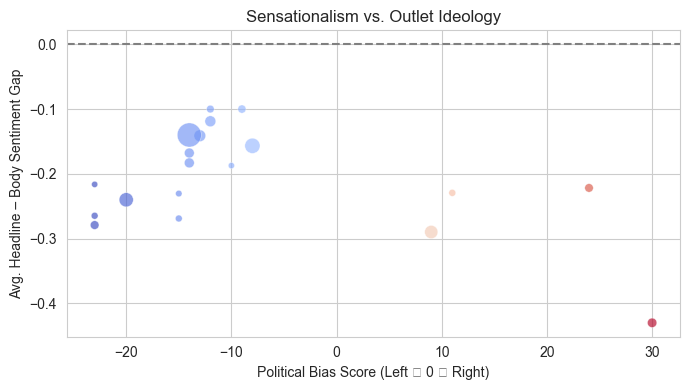

/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_97055/232094612.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="bias_bucket", y="sent_gap",


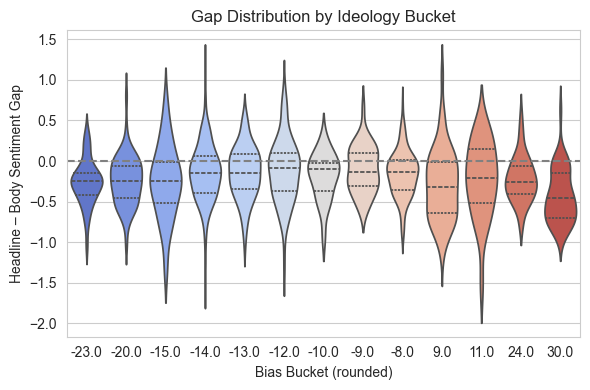

In [43]:
# 5. Exploratory visuals
# 5a – Bubble chart (outlet level, n≥5)
outlet_stats = (df.dropna(subset=["bias_rating"])
                  .groupby("domain")
                  .agg(n=('sent_gap','size'),
                       mean_gap=('sent_gap','mean'),
                       bias=('bias_rating','first'))
                  .query("n >= 5")
                  .reset_index())

plt.figure(figsize=(7,4))
sns.scatterplot(data=outlet_stats,
                x="bias", y="mean_gap",
                size="n", sizes=(20,300),
                hue="bias", palette="coolwarm", legend=False, alpha=0.65)
plt.axhline(0, ls="--", c="grey")
plt.xlabel("Political Bias Score (Left ⟵ 0 ⟶ Right)")
plt.ylabel("Avg. Headline – Body Sentiment Gap")
plt.title("Sensationalism vs. Outlet Ideology")
plt.tight_layout()
plt.savefig(RES_DIR/"bias_bubble.png", dpi=300)
plt.show()

# 5b – Violin plot by rounded bias bucket
df["bias_bucket"] = df["bias_rating"].dropna().round()  # round to nearest int
plt.figure(figsize=(6,4))
sns.violinplot(x="bias_bucket", y="sent_gap",
               data=df.dropna(subset=["bias_bucket"]),
               palette="coolwarm", inner="quartile")
plt.axhline(0, ls="--", c="grey")
plt.xlabel("Bias Bucket (rounded)")
plt.ylabel("Headline – Body Sentiment Gap")
plt.title("Gap Distribution by Ideology Bucket")
plt.tight_layout()
plt.savefig(RES_DIR/"bias_violin.png", dpi=300)
plt.show()

In [45]:
# ----------------------------------------------------------------
# 6. Spearman correlation (article‑level)
sub = df.dropna(subset=["bias_rating", "sent_gap"])
rho, p = spearmanr(sub["bias_rating"], sub["sent_gap"])
print(f"Spearman ρ = {rho:.2f}  (p = {p:.3g})")

Spearman ρ = -0.02  (p = 0.395)


In [46]:
# ----------------------------------------------------------------
# 7. Save merged dataset for future use
OUT_PATH = "../data/full_articles_with_bias.csv"
df.to_csv(OUT_PATH, index=False)
print(f"✓ saved → {OUT_PATH}")

✓ saved → ../data/full_articles_with_bias.csv
